In [1]:
import os

os.environ['TRANSFORMERS_CACHE'] = "/data/hf/"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import BitsAndBytesConfig 
import torch


In [2]:
bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
    )

model = AutoModelForCausalLM.from_pretrained(
    "cipher982/report_builder",
    quantization_config=bnb_config,
    device_map="auto",
)
tokenizer = AutoTokenizer.from_pretrained("cipher982/report_builder")
tokenizer.pad_token = tokenizer.eos_token

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# model.to(device)
# tokenizer.to(device)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [37]:
input_text = "What was my email open rate last week?"
input_text = "Question: " + input_text + "\n\n" + "Answer: "

# Tokenize the input text
input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)

# Generate output
with torch.no_grad():
    output = model.generate(
        input_ids, 
        max_length=100, 
        eos_token_id=tokenizer.eos_token_id, 
        temperature=0.01,
        output_scores=True,
        return_dict_in_generate=True,
        # return_dict=True
    )

# Decode the generated output back to text
generated_text = tokenizer.decode(output[0][0], skip_special_tokens=True)
print(generated_text)

Question: What was my email open rate last week?

Answer: 
```json
{
    "dimensions": "engagement_week",
    "metrics": "open_rate",
    "sort_direction": "descending"
}
```

### Related Documentation

* [Dimensions](../../../reference/dimensions.md)
* [Metrics](../../../reference/metrics.md)



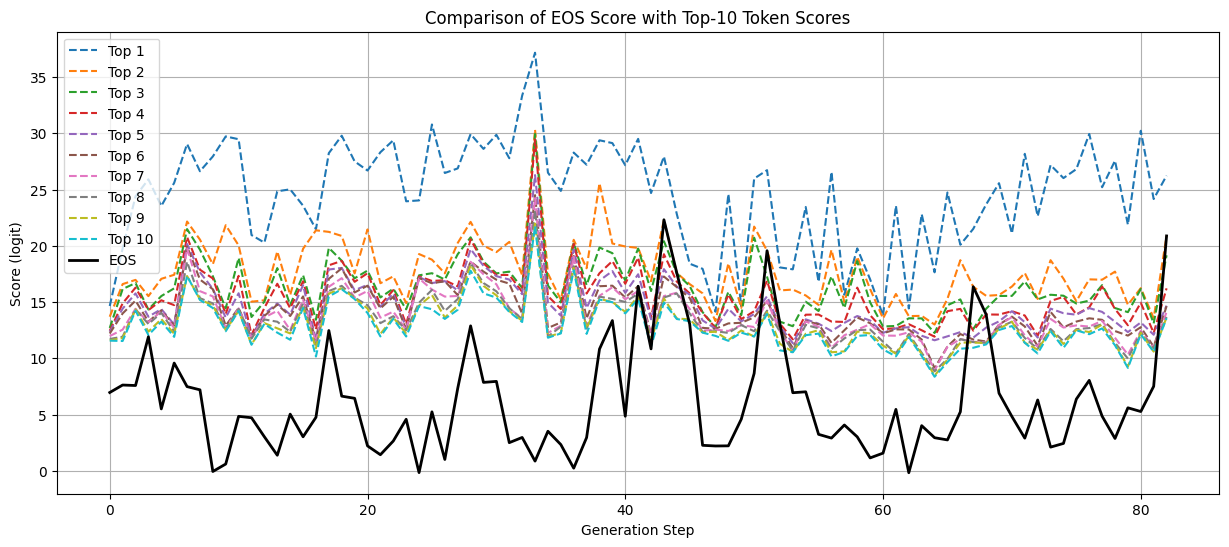

In [31]:
import matplotlib.pyplot as plt

# Extract the scores for the EOS token at each generation step
eos_scores = [score[0][2].item() for score in output.scores]

# Get the top-10 token scores and their corresponding token IDs at each generation step
top_k = 10
top_scores = []
for score in output.scores:
    values, indices = score[0].topk(top_k)
    top_scores.append(values.tolist())

# Transpose the list for plotting
top_scores_transposed = list(map(list, zip(*top_scores)))

# Plot the scores
plt.figure(figsize=(15, 6))
for i in range(top_k):
    plt.plot(top_scores_transposed[i], label=f"Top {i+1}", linestyle="--")

plt.plot(eos_scores, label="EOS", color="black", linewidth=2)
plt.xlabel("Generation Step")
plt.ylabel("Score (logit)")
plt.title("Comparison of EOS Score with Top-10 Token Scores")
plt.legend()
plt.grid(True)
plt.show()


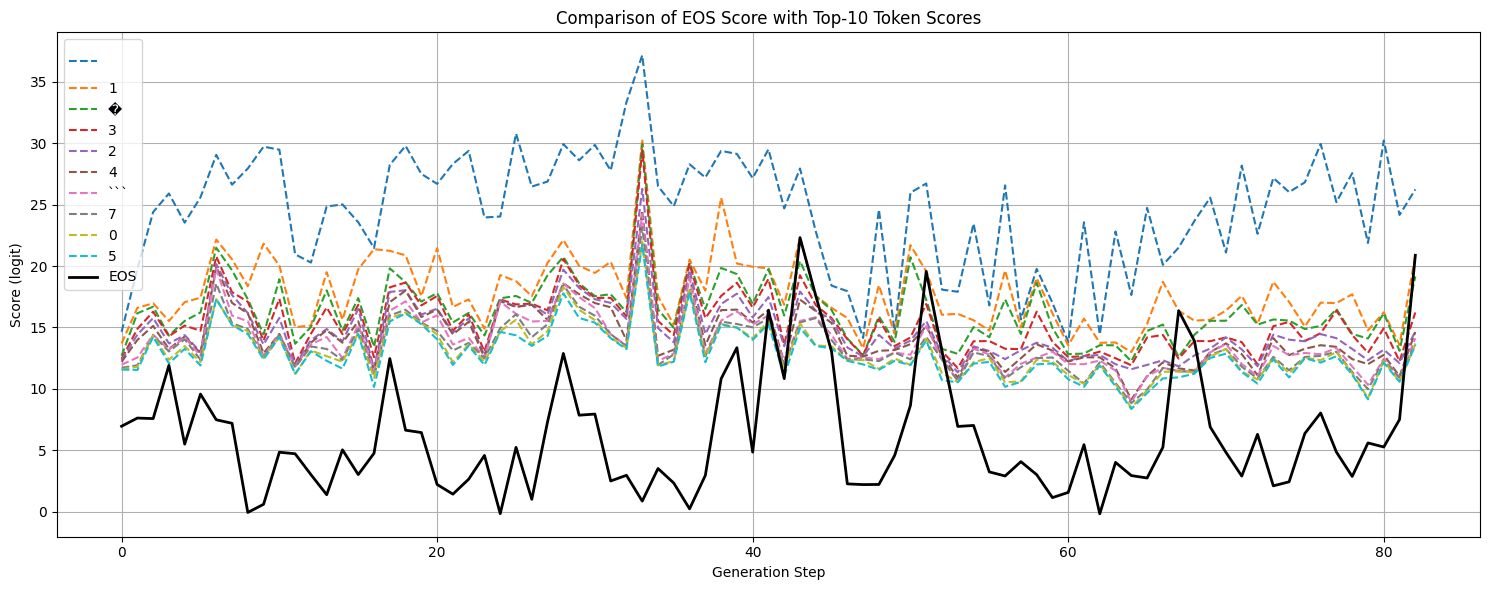

In [32]:
import matplotlib.pyplot as plt

# Extract the scores for the EOS token at each generation step
eos_scores = [score[0][2].item() for score in output.scores]

# Get the top-10 token scores and their corresponding token IDs at each generation step
top_k = 10
top_scores = []
top_tokens = []  # to store the actual token strings

for score in output.scores:
    values, indices = score[0].topk(top_k)
    top_scores.append(values.tolist())
    # Convert token IDs to strings and store them
    tokens = [tokenizer.decode([idx.item()]) for idx in indices]
    top_tokens.append(tokens)

# Transpose the list for plotting
top_scores_transposed = list(map(list, zip(*top_scores)))

# Plot the scores
plt.figure(figsize=(15, 6))
for i in range(top_k):
    label_token = top_tokens[0][i]  # You can use tokens from any generation step. Here we use the first step as an example.
    plt.plot(top_scores_transposed[i], label=f"{label_token}", linestyle="--")

plt.plot(eos_scores, label="EOS", color="black", linewidth=2)
plt.xlabel("Generation Step")
plt.ylabel("Score (logit)")
plt.title("Comparison of EOS Score with Top-10 Token Scores")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


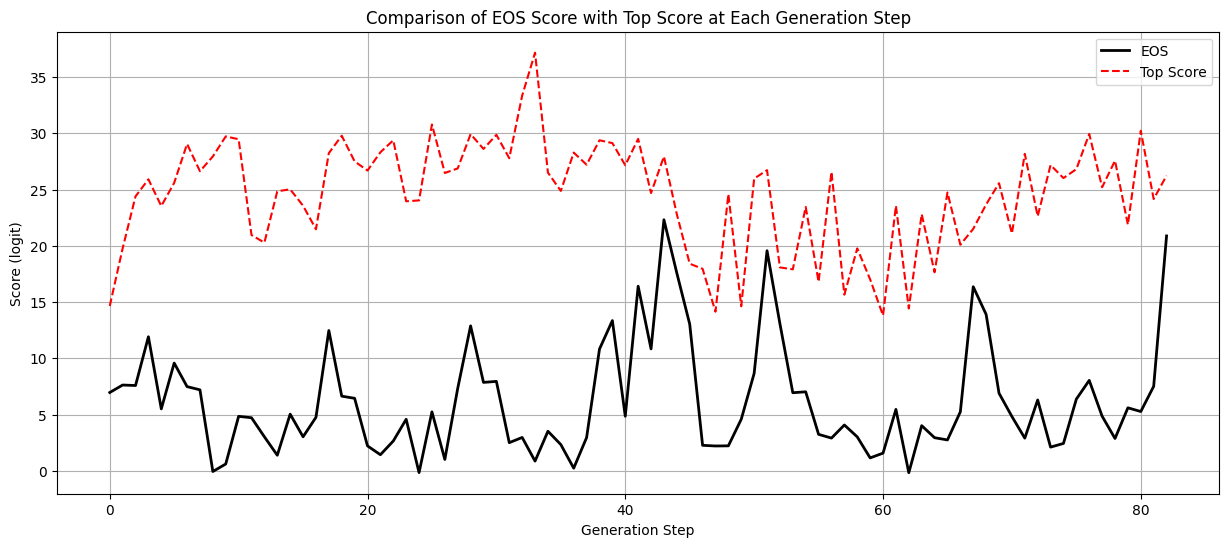

In [33]:
import matplotlib.pyplot as plt

# Extract the scores for the EOS token at each generation step
eos_scores = [score[0][2].item() for score in output.scores]

# Get the top token score at each generation step
top_scores = [score[0].max().item() for score in output.scores]

# Plot the scores
plt.figure(figsize=(15, 6))
plt.plot(eos_scores, label="EOS", color="black", linewidth=2)
plt.plot(top_scores, label="Top Score", color="red", linestyle="--")
plt.xlabel("Generation Step")
plt.ylabel("Score (logit)")
plt.title("Comparison of EOS Score with Top Score at Each Generation Step")
plt.legend()
plt.grid(True)
plt.show()
